In [398]:
# Import necessary packages
import pandas as pd

In [399]:
# Load dataset
df = pd.read_csv('job_opportunities.csv', encoding='ISO-8859-1')

In [400]:
df.head()

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,"
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,NaN,90K+ *,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,"
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,"
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi..."


## Cleaning

#### Pre-cleaning

In [3]:
# Make some pre-cleanings
df.rename(columns={'Requirment of the company ': 'Requirment of the company'}, inplace=True)

# Drop last row
df.drop(df.loc[df['Company'].isnull()].index, axis='rows', inplace=True)

# Drop duplicated rows
df.drop_duplicates(inplace=True)

In [4]:
# Standardize job title
df['Job Title'] = df['Job Title'].apply(lambda x: str.lower(str.strip(x)))
df['Location'] = df['Location'].apply(lambda x: str.lower(str.strip(x)))

# Drop duplicated rows
df.drop_duplicates(inplace=True)

#### Salary

In [5]:
# Save null salary in another dataframe
df_salary_isnull = df.loc[df['Salary'].isnull()]

# Delete those null salary from the main dataframe
df.drop(df_salary_isnull.index, inplace=True)

# Create new column that contains stars True or False
df['Salary_has_star'] = df['Salary'].str.contains('\*')

# Take +, *, and K from salary 
df['Salary'] = df['Salary'].apply(lambda x: str.replace(x, '+', ''))
df['Salary'] = df['Salary'].apply(lambda x: str.replace(x, '*', ''))
df['Salary'] = df['Salary'].apply(lambda x: str.replace(x, 'K', ''))
df['Salary'] = df['Salary'].apply(lambda x: str.strip(x))

In [6]:
# Function is_number
def is_number(number):
    try:
        number = float(number)
        return isinstance(number, float)
    except:
        return False
    
# Function take_currency
import re
def take_currency(salary):
    salary = re.sub(r'[0-9+]', '', salary)
    return str.strip(salary)

# Function remove_currency
def remove_currency(salary):
    salary = re.sub(r'[^0-9]', '', salary)
    return salary

In [7]:
# Create new column that contain the currency
df['Currency'] = df['Salary'].apply(lambda x: 'USD' if is_number(x) else take_currency(x))

# Remove currency from salary
df['Salary'] = df['Salary'].apply(lambda x: remove_currency(x))

# Change salary type to float and multiply to 1000
df['Salary'] = df['Salary'].astype(float) * 1000

df.reset_index(drop=True, inplace=True)

In [8]:
# Normalize salary
from currency_converter import CurrencyConverter

converter = CurrencyConverter()

for i in range(len(df)):
    currency = df['Currency'][i]

    if currency != 'USD':
        df['Salary'][i] = converter.convert(df['Salary'][i], currency, "USD")

/tmp/ipykernel_6807/69151303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Salary'][i] = converter.convert(df['Salary'][i], currency, "USD")


In [9]:
# Drop the currency column after transforming the salary
df.drop('Currency', axis='columns', inplace=True)

#### Location

In [10]:
# Drop unecessary white spaces in location
df['Location'] = df['Location'].apply(lambda x: str.lower(str.strip(x)))

In [11]:
# # Import Geotext
# from geotext import GeoText

# # Create country column
# df['Country'] = df['Location'].apply(lambda x: GeoText(x).countries[0] if len(GeoText(x).countries) > 0 else None)

#### Requirement and facilities

In [11]:
# Change those to list
df['Requirment of the company'] = df['Requirment of the company'].apply(lambda x: str.split(x, ','))
df['Facilities'] = df['Facilities'].apply(lambda x: str.split(x, ','))

In [12]:
# Create function to delete all empty strings
def delete_empty_in_list(listname):
    while '' in listname:
        listname.remove('')
    return listname

In [13]:
# Remove empty strings on the lists
df['Requirment of the company'] = df['Requirment of the company'].apply(lambda x: delete_empty_in_list(x))
df['Facilities'] = df['Facilities'].apply(lambda x: delete_empty_in_list(x))

In [14]:
# Handle empty facilities
df['Facilities'] = df['Facilities'].apply(lambda x: ['No facilities'] if len(x) == 0 else x)

#### Experience level

In [15]:
# Handle experience level null values
df['Experience level'] = df['Experience level'].apply(lambda x: 'Not specified' if pd.isnull(x) else x)

#### Job category

In [16]:
# Create keywords for jobs
data_science_keywords = [
    'scientist', 'science', 'data analysis', 'data analyst', 'data mining', 'predictive modeling',
    'machine learning', 'statistical analysis', 'data visualization',
    'exploratory data analysis', 'data cleaning', 'feature engineering',
    'regression analysis', 'classification', 'clustering',
    'natural language processing', 'time series analysis', 'data product manager', 'research analyst', 'data analytics',
    'data quality', 'bi', 'business intelligence', 'data management', 'data project management', 'digital analytics',
    'data modeler', 'data product owner', 'cloud database analyst', 'data manager', 'data strategy', 'data specialist',
    'analytics engineer', 'master data', 'data operations', 'data operator', 'dataops', 'data strategist', 'data systems',
    'data reporter', 'data and control systems', 'data developer', 'data analyse', 'data visualisation', 'analyst',
    'data strategies', 'head of data', 'ml'
]

big_data_keywords = [
    'big', 'big data', 'data engineer', 'data enginner','hadoop', 'apache spark', 'spark', 'nosql', 'mapreduce',
    'distributed computing', 'data storage and retrieval', 'data scalability', 'etl',
    'data volume', 'data velocity', 'data variety', 'data processing',
    'data architecture', 'data streaming', 'data lakes', 'streaming data pipelines', 'data architect', 'data storage',
    'data pipeline', 'data platform', 'dataset', 'databricks', 'data integrations', 'data infrastructure', 'data integration',
    'database engineer', 'data lake', 'data modeller', 'data production', 'cloud data', 'data modelling', 'data modeling',
    'database tools'
]

ai_keywords = [
    'artificial intelligence', 'ai', 'machine learning', 'deep learning',
    'neural networks', 'natural language processing', 'computer vision',
    'reinforcement learning', 'robotics', 'expert systems',
    'cognitive computing', 'ai algorithms', 'sentiment analysis',
    'speech recognition', 'image recognition', 'autonomous systems', 'ml',
    'autonomous', 'autonomy', 'robotic', 'vision', 'text analytics', 'chatbot', 'nlp', 'model inference'
]

In [17]:
# Function to classify job titles into DS, AI or Big Data
def classify_job(title):
    str.lower(title)
    categories = []
    if any(keyword in title for keyword in ai_keywords):
        categories.append('Artificial Intelligence')
    if any(keyword in title for keyword in data_science_keywords):
        categories.append('Data Science')
    if any(keyword in title for keyword in big_data_keywords):
        categories.append('Big Data')
    if not categories :
        categories.append('Other')
    return categories

In [18]:
# Create Job Category column
df['Job Category'] = df['Job Title'].apply(lambda x: classify_job(x.lower()))

In [19]:
# Display dataframe head
df.head()

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities,Salary_has_star,Job Category
0,SGS,clinical data analyst,"richardson, tx, united states",Full Time,Entry-level,48000.0,"[Computer Science, Data quality, Genetics, Mat...",[No facilities],True,[Data Science]
1,Ocorian,aml/cft & data analyst,"ebène, mauritius",Full Time,Entry-level,48000.0,"[Agile, Data management, Finance, Security]",[No facilities],True,"[Artificial Intelligence, Data Science]"
2,Cricut,machine learning engineer,"south jordan, ut, united states",Full Time,Not specified,90000.0,"[Agile, Architecture, AWS, Computer Science, C...",[Career development],True,"[Artificial Intelligence, Data Science]"
3,Bosch Group,application developer & data analyst,"nonantola, italy",Full Time,Entry-level,48000.0,"[Engineering, Industrial, Oracle, Power BI, R,...",[No facilities],True,[Data Science]
4,Publicis Groupe,data engineer full time (public sector) usa,"arlington, va, united states",Full Time,Mid-level,108000.0,"[AWS, Azure, Computer Science, Consulting, Dat...","[Flex hours, Flex vacation, Parental leave, Un...",False,[Big Data]


## Stockage

In [20]:
# Import necessary packages
from sqlalchemy import create_engine, text, Integer, String, Float, Boolean, Date, Column, inspect, UniqueConstraint, ForeignKey, func, desc, select, Index, distinct
from sqlalchemy.orm import create_session, declarative_base, Relationship, sessionmaker

username = 'SA'
password = 'YourPassword123'
hostname = '172.17.0.1'
database = 'job_opportunities'
driver = 'ODBC+Driver+18+for+SQL+Server'

connection_string = f'mssql+pyodbc://{username}:{password}@{hostname}/{database}?driver={driver}&Encrypt=No'

# Create sqlalchemy engine
engine = create_engine(connection_string)

In [22]:
# Create tables

# Create a base
Base = declarative_base()

# locations
class Locations(Base):
    __tablename__ = 'locations'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    location = Column(String(255), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(location, name='locations_location_UQ'),)

# facilities
class Facilities(Base):
    __tablename__ = 'facilities'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    facility = Column(String(255), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(facility, name='facilities_facility_UQ'),)

    # Indexes
    facility_index = Index('facilities_facility', facility)

# job_types
class JobTypes(Base):
    __tablename__ = 'job_types'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    type = Column(String(50), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(type, name='job_types_type_UQ'),)

# experience_levels
class ExperienceLevels(Base):
    __tablename__ = 'experience_levels'
    
    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    level = Column(String(50), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(level, name='experience_levels_level_UQ'),)

# requirements
class Requirements(Base):
    __tablename__ = 'requirements'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    requirement = Column(String(255), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(requirement, name='requirements_requirement_UQ'),)

    # Indexes
    requirement_index = Index('requirements_requirement_index', requirement)

# companies
class Companies(Base):
    __tablename__ = 'companies'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    company = Column(String(255), nullable=False)

    # constraints
    __table_args__ = (UniqueConstraint(company, name='companies_company_UQ'),)

    # Indexes
    company_index = Index('companies_company_index', company)

# jobs
class Jobs(Base):
    __tablename__ = 'jobs'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    title = Column(String(255), nullable=False)
    salary = Column(Float, nullable=False)
    salary_has_star = Column(Boolean, nullable=False)
    job_type_id = Column(Integer, ForeignKey('job_types.id'))
    location_id = Column(Integer, ForeignKey('locations.id'))
    experience_level_id = Column(Integer, ForeignKey('experience_levels.id'))
    company_id = Column(Integer, ForeignKey('companies.id'))

    # UniqueConstraint
    __table_args__ = (UniqueConstraint(
        title, 
        salary, 
        salary_has_star, 
        job_type_id,
        location_id,
        experience_level_id,
        company_id,
        name='jobs_UQ'
    ),)

    # Relationships
    job_types_jobs = Relationship('JobTypes', backref='jobs')
    locations_jobs = Relationship('Locations', backref='jobs')
    experience_levels_jobs = Relationship('ExperienceLevels', backref='jobs')
    companies_jobs = Relationship('Companies', backref='jobs')

    # Indexes
    title_index = Index('jobs_title_index', title)
    salary_index = Index('jobs_salary_index', salary)

# job_facilities
class JobFacilities(Base):
    __tablename__ = 'job_facilities'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    job_id = Column(Integer, ForeignKey('jobs.id'))
    facility_id = Column(Integer, ForeignKey('facilities.id'))

    # Unique constraints
    __table_args__ = (UniqueConstraint(job_id, facility_id, name='job_facility_UQ'),)

    # Relationships
    job_jf = Relationship('Jobs', backref='job_facilities')
    facility_fj = Relationship('Facilities', backref='job_facilities')

# job_requirements
class JobRequirements(Base):
    __tablename__ = 'job_requirements'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    requirement_id = Column(Integer, ForeignKey('requirements.id'))
    job_id = Column(Integer, ForeignKey('jobs.id'))

    # Unique constraints
    __table_args__ = (UniqueConstraint(requirement_id, job_id, name='job_requirements_UQ'),)

    # Relationships
    requirement_jr = Relationship('Requirements', backref='job_requirements')
    job_jr = Relationship('Jobs', backref='job_requirements')


# Categories
class Categories(Base):
    __tablename__ = 'categories'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    category = Column(String(255), nullable=False)

    # UniqueConstraints
    __table_args__ = (UniqueConstraint(category, name='categories_category_UQ'),)

    # Indexes
    category_index = Index('categories_category_index', category)

# Job_categories
class JobCategories(Base):
    __tablename__ = 'job_categories'

    # Column
    id = Column(Integer, primary_key=True, autoincrement=True)
    category_id = Column(Integer, ForeignKey('categories.id'))
    job_id = Column(Integer, ForeignKey('jobs.id'))

    # Unique constraints
    __table_args__ = (UniqueConstraint(category_id, job_id, name='job_categories_UQ'),)

    # Relationships
    category_jc = Relationship('Categories', backref='job_categories')
    job_jc = Relationship('Jobs', backref='job_categories')

try:
    Base.metadata.create_all(engine)
    print('Tables created successfully')
except Exception as ex:
    print(ex)

Tables created successfully


In [276]:
# Check if tables are created
inspector = inspect(engine)

inspector.get_table_names()

['categories',
 'companies',
 'experience_levels',
 'facilities',
 'job_categories',
 'job_facilities',
 'job_requirements',
 'job_types',
 'jobs',
 'locations',
 'requirements']

In [24]:
# Create session
session = create_session(engine)

### Insertion des données dans la base

In [96]:
# Tables that don't have foregin keys
try:
    # Locations
    for location in df['Location'].unique():
        new_location = Locations(location=str(location))
        session.add(new_location)

    # Facilities
    for facility in df['Facilities'].explode().unique():
        new_facility = Facilities(facility=str(facility))
        session.add(new_facility)

    # Categories
    for category in df['Job Category'].explode().unique():
        new_category = Categories(category=str(category))
        session.add(new_category)

    # Requirements
    for requirement in df['Requirment of the company'].explode().unique():
        new_requirement = Requirements(requirement=str(requirement))
        session.add(new_requirement)

    # Experience levels
    for experience_level in df['Experience level'].unique():
        new_experience_level = ExperienceLevels(level=str(experience_level))
        session.add(new_experience_level)

    # Job types
    for job_type in df['Job Type'].unique():
        new_job_type = JobTypes(type=str(job_type))
        session.add(new_job_type)

    # Companies
    for company in df['Company'].unique():
        new_company = Companies(company=str.capitalize(str.strip(company)))
        session.add(new_company)

    session.commit()
    print('All rows inserted successfully')
except Exception as e:
    session.rollback()
    print('Error', e)
    print('No row inserted')
finally:
    session.close()

All rows inserted successfully


In [25]:
# Check if the insertion went good
df['Company'].explode().unique().shape[0] == session.query(Companies).count()

True

In [26]:
# Create job dataframe
job_columns = [
    'Job Title', 
    'Salary', 
    'Salary_has_star', 
    'Job Type', 
    'Location',
    'Experience level',
    'Company'
]
jobs_df = df[job_columns]
jobs_df.drop_duplicates(inplace=True)
jobs_df.reset_index(inplace=True, drop=True)

/tmp/ipykernel_6807/1828438676.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_df.drop_duplicates(inplace=True)


In [102]:
# Create session
session = create_session(engine)

# insert into jobs
with session.begin():
    try:
        for i in range(len(jobs_df)):
            title = jobs_df['Job Title'][i]
            salary = float(jobs_df['Salary'][i])
            salary_has_star = bool(jobs_df['Salary_has_star'][i])
            job_type = jobs_df['Job Type'][i]
            job_type_id = session.query(JobTypes).filter(JobTypes.type==job_type).first().id
            location = jobs_df['Location'][i]
            location_id = session.query(Locations).filter_by(location=location).first().id
            experience_level = jobs_df['Experience level'][i]
            experience_level_id = session.query(ExperienceLevels).filter_by(level=experience_level).first().id
            company = str.capitalize(str.strip(jobs_df['Company'][i]))
            company_id = session.query(Companies).filter_by(company=company).first().id

            # new jobs
            new_job = Jobs(
                title=title,
                salary=salary,
                salary_has_star=salary_has_star,
                job_type_id=job_type_id,
                location_id=location_id,
                experience_level_id=experience_level_id,
                company_id=company_id
            )
            session.add(new_job)

        # Commit the transaction
        session.commit()
        print('All rows inserted successfully')
    except Exception as e:
        # Roll back the transaction
        session.rollback()
        print('Error ',e)
        print('No row inserted')
session.close()

All rows inserted successfully


In [27]:
# Check if the insertion went good
jobs_df.shape[0] == session.query(Jobs).count()

True

In [28]:
# Job facilities df
job_facilities_columns = job_columns + ['Facilities']
job_facilities_df = df[job_facilities_columns].explode('Facilities', ignore_index=True)
job_facilities_df['Facilities'] = job_facilities_df['Facilities'].apply(lambda x: str.lower(str.strip(x)))
job_facilities_df.drop_duplicates(inplace=True)
job_facilities_df.reset_index(inplace=True, drop=True)

In [111]:
# Insert into job facilities 

print(f"{job_facilities_df.shape[0]} rows to insert\n")

# Create a session
Session = sessionmaker(bind=engine)
session = Session()

for i in range(len(job_facilities_df)):
    with session.begin():
        try:
            # Get job id
            title = job_facilities_df['Job Title'][i]
            salary = job_facilities_df['Salary'][i]
            salary_has_star = job_facilities_df['Salary_has_star'][i]
            job_type = job_facilities_df['Job Type'][i]
            job_type_id = session.query(JobTypes).filter_by(type=job_type).first().id
            location = job_facilities_df['Location'][i]
            location_id = session.query(Locations).filter_by(location=location).first().id
            experience_level = job_facilities_df['Experience level'][i]
            experience_level_id = session.query(ExperienceLevels).filter_by(level=experience_level).first().id
            company = str.capitalize(str.strip(job_facilities_df['Company'][i]))
            company_id = session.query(Companies).filter_by(company=company).first().id
            job_id = session.query(Jobs).filter_by(
                title=title,
                salary=salary,
                salary_has_star=salary_has_star,
                job_type_id=job_type_id,
                location_id=location_id,
                experience_level_id=experience_level_id,
                company_id=company_id
            ).first().id

            # Get facility id
            facility = job_facilities_df['Facilities'][i]
            facility_id = session.query(Facilities).filter_by(facility=facility).first().id

            # New row 
            new_row_job_facility = JobFacilities(job_id=job_id, facility_id=facility_id)
            session.add(new_row_job_facility)

            # Commit the transaction
            session.commit()
            print(f"Row {i} inserted successfully", end='\r')
        except Exception as e:
            # Roll back the transaction
            session.rollback()
            print(f"Row {i} has a problem")
            print(e)
            break

8442 rows to insert



In [29]:
# Check if the insertion went good
job_facilities_df.shape[0] == session.query(JobFacilities).count()

True

In [30]:
# Job categories df
job_categories_columns = job_columns + ['Job Category']
job_categories_df = df[job_categories_columns].explode('Job Category', ignore_index=True)
job_categories_df['Job Category'] = job_categories_df['Job Category'].apply(lambda x: str.lower(str.strip(x)))
job_categories_df.drop_duplicates(inplace=True)
job_categories_df.reset_index(inplace=True, drop=True)

In [118]:
# Insert into job Categories
print(f"{job_categories_df.shape[0]} rows to insert\n")

# Create a session
Session = sessionmaker(bind=engine)
session = Session()

for i in range(len(job_categories_df)):
    with session.begin():
        try:
            # Get category id 
            category = job_categories_df['Job Category'][i]
            category_id = session.query(Categories).filter_by(category=category).first().id

            # Get job id
            title = job_categories_df['Job Title'][i]
            salary = job_categories_df['Salary'][i]
            salary_has_star = job_categories_df['Salary_has_star'][i]
            job_type = job_categories_df['Job Type'][i]
            job_type_id = session.query(JobTypes).filter_by(type=job_type).first().id
            location = job_categories_df['Location'][i]
            location_id = session.query(Locations).filter_by(location=location).first().id
            experience_level = job_categories_df['Experience level'][i]
            experience_level_id = session.query(ExperienceLevels).filter_by(level=experience_level).first().id
            company = str.capitalize(str.strip(job_categories_df['Company'][i]))
            company_id = session.query(Companies).filter_by(company=company).first().id
            job_id = session.query(Jobs).filter_by(
                title=title,
                salary=salary,
                salary_has_star=salary_has_star,
                job_type_id=job_type_id,
                location_id=location_id,
                experience_level_id=experience_level_id,
                company_id=company_id
            ).first().id

            # New row 
            new_row_job_category = JobCategories(job_id=job_id, category_id=category_id)
            session.add(new_row_job_category)

            # Commit the transaction
            session.commit()
            print(f"Row {i} inserted successfully", end='\r')
        except Exception as e:
            # Roll back the transaction
            session.rollback()
            print(f"Row {i} has a problem")
            print(e)
            break

3329 rows to insert



In [31]:
# Check if the insertion went good
job_categories_df.shape[0] == session.query(JobCategories).count()

True

In [32]:
# Job requirements df
job_requirements_columns = job_columns + ['Requirment of the company']
job_requirements_df = df[job_requirements_columns].explode('Requirment of the company', ignore_index=True)
job_requirements_df['Requirment of the company'] = job_requirements_df['Requirment of the company'].apply(lambda x: str.lower(str.strip(x)))
job_requirements_df.drop_duplicates(inplace=True)
job_requirements_df.reset_index(inplace=True, drop=True)

In [121]:
# Insert into job requirements
print(f"{job_requirements_df.shape[0]} rows to insert\n")

# Create a session
Session = sessionmaker(bind=engine)
session = Session()

for i in range(len(job_requirements_df)):
    with session.begin():
        try:
            # Get requirement id 
            requirement = job_requirements_df['Requirment of the company'][i]
            requirement_id = session.query(Requirements).filter_by(requirement=requirement).first().id

            # Get job id
            title = job_requirements_df['Job Title'][i]
            salary = job_requirements_df['Salary'][i]
            salary_has_star = job_requirements_df['Salary_has_star'][i]
            job_type = job_requirements_df['Job Type'][i]
            job_type_id = session.query(JobTypes).filter_by(type=job_type).first().id
            location = job_requirements_df['Location'][i]
            location_id = session.query(Locations).filter_by(location=location).first().id
            experience_level = job_requirements_df['Experience level'][i]
            experience_level_id = session.query(ExperienceLevels).filter_by(level=experience_level).first().id
            company = str.capitalize(str.strip(job_requirements_df['Company'][i]))
            company_id = session.query(Companies).filter_by(company=company).first().id
            job_id = session.query(Jobs).filter_by(
                title=title,
                salary=salary,
                salary_has_star=salary_has_star,
                job_type_id=job_type_id,
                location_id=location_id,
                experience_level_id=experience_level_id,
                company_id=company_id
            ).first().id

            # New row 
            new_row_job_requirement = JobRequirements(job_id=job_id, requirement_id=requirement_id)
            session.add(new_row_job_requirement)

            # Commit the transaction
            session.commit()
            print(f"Row {i} inserted successfully", end='\r')
        except Exception as e:
            # Roll back the transaction
            session.rollback()
            print(f"Row {i} has a problem")
            print(e)
            break

16027 rows to insert



In [397]:
# Check if the insertion went good
job_requirements_df.shape[0] == session.query(JobRequirements).count()
session.query(JobRequirements).count()

16027

### Analyse et visualisation

#### Quel est le marché le plus demandé ?

In [275]:
# Get the most demanded areas
result = session.query(Categories.category, func.count(JobCategories.job_id)).\
    join(Categories).\
    group_by(Categories.category).\
    order_by(desc(func.count(JobCategories.job_id))).\
    all()

most_demanded_job = {x[0]: x[1] for x in result}

most_demanded_job

{'Data Science': 1942,
 'Big Data': 695,
 'Artificial Intelligence': 634,
 'Other': 58}

In [387]:
# Import bokeh packages
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.palettes import GnBu3, OrRd3, Category20c
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.transform import cumsum, factor_cmap, dodge

In [252]:
# Bar chart for most demands area
output_notebook()

jobs_categories = list(most_demanded_job.keys())
job_counts = list(most_demanded_job.values())

most_demanded_job_plot = figure(width=400, height=400, x_range=jobs_categories)
most_demanded_job_plot.vbar(x=jobs_categories, top=job_counts, width=0.5, bottom=0, color='darkblue')

# Labels
most_demanded_job_plot.xaxis.axis_label = 'Job Categories'
most_demanded_job_plot.yaxis.axis_label = 'Nombre d\'apparition'
most_demanded_job_plot.title.text = 'Le marché les plus demandés'

show(most_demanded_job_plot)

Loading BokehJS ...

### Compétences les plus demandés

In [180]:
# Function to retrieve most demands requirement by category
sql = text('''
    CREATE FUNCTION GetRequirementsCountByCategory (@categoryName VARCHAR(255))
    RETURNS TABLE
    AS
    RETURN
    (
        SELECT r.requirement, COUNT(jr.job_id) AS job_count
        FROM requirements r
        JOIN job_requirements jr ON r.id = jr.requirement_id
        JOIN jobs j ON j.id = jr.job_id
        JOIN job_categories jc ON j.id = jc.job_id
        JOIN categories c ON c.id = jc.category_id
        WHERE c.category = @categoryName
        GROUP BY r.requirement
    );
''')

# Execute the query to create the function
with engine.connect() as conn:
    conn.execute(sql)
    conn.commit()

In [266]:
# Optionnal
result = session.query(Requirements.requirement, func.count(JobRequirements.job_id)).\
    join(JobRequirements).\
    join(Jobs).\
    join(JobCategories).\
    join(Categories).\
    filter(Categories.category=='data science').\
    group_by(Requirements.requirement).\
    order_by(desc(func.count(JobCategories.job_id))).\
    all()

most_demand_skills = {x[0]: x[1] for x in result}
most_demand_skills_df = pd.DataFrame(data=list(most_demand_skills.items()), columns=['Skill', 'Job Count'])

In [36]:
# Function to het the most demanded skills
def get_requirements_count_by_category(category_name):
    query = text(f"SELECT * FROM GetRequirementsCountByCategory(:categoryName) ORDER BY job_count DESC")
    result = session.execute(query, {'categoryName': category_name})
    # Create dict containing results
    most_demand_skills = {x[0]: x[1] for x in result.fetchall()}
    # Transform dict to dataframe
    most_demand_skills_df = pd.DataFrame(data=list(most_demand_skills.items()), columns=['Skill', 'Job Count'])
    return most_demand_skills_df

#### Data Science 

In [37]:
# Retrieve requirements from database and their counts where category is Data Science
data_science_skills = get_requirements_count_by_category('data science')
data_science_skills.head()

,Skill,Job Count
0,Computer Science,691
1,Engineering,668
2,Data analysis,428
3,AWS,406
4,Machine Learning,360


In [253]:
# Import plotly necessary packages
import plotly.express as px

In [254]:
# Bar chart for most demanded skills in data science
number_of_line = 20
skills = data_science_skills.head(number_of_line)['Skill']
jobs_counts = data_science_skills.head(number_of_line)['Job Count']

# Create the bar chart
skills_fig = px.bar(
    x=skills, 
    y=jobs_counts, 
    labels={'x': 'Compétences', 'y': 'Nombre de demandes'}, title='Compétences les plus demandés en Data Science',
    color=data_science_skills.head(number_of_line)['Job Count']
)


# Customize the layout
skills_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#101F6A',
    paper_bgcolor='#17266D',
    xaxis_showgrid=False,
    yaxis_showgrid=True
)

# Show the plot in notebook
skills_fig.show()

#### Big Data

In [39]:
# Retrieve requirements where category is Big DATA
big_data_skills = get_requirements_count_by_category('Big data')
big_data_skills.head()

,Skill,Job Count
0,AWS,366
1,Architecture,326
2,Azure,254
3,Computer Science,249
4,Big Data,236


In [255]:
# Bar chart for most demanded skills in big data
number_of_line = 20
skills = big_data_skills.head(number_of_line)['Skill']
jobs_counts = big_data_skills.head(number_of_line)['Job Count']

# Create the bar chart
skills_fig = px.bar(
    x=skills, 
    y=jobs_counts, 
    labels={'x': 'Compétences', 'y': 'Nombre de demandes'}, title='Compétences les plus demandés en Big DATA',
)


# Customize the layout
skills_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#101F6A',
    paper_bgcolor='#17266D',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

# Show the plot in notebook
skills_fig.show()

#### Artificial Intelligence

In [256]:
# Get most demanded skills in AI
ai_skills = get_requirements_count_by_category('artificial intelligence')
ai_skills.head()

,Skill,Job Count
0,Computer Science,310
1,Engineering,297
2,Machine Learning,199
3,Architecture,178
4,AWS,175


In [257]:
# Bar chart for most demanded skills in AI
number_of_line = 20
skills = ai_skills.head(number_of_line)['Skill']
jobs_counts = ai_skills.head(number_of_line)['Job Count']

# Create the bar chart
skills_fig = px.bar(
    x=skills, 
    y=jobs_counts, 
    labels={'x': 'Compétences', 'y': 'Nombre de demandes'}, title='Compétences les plus demandés en Intelligence Artificielle',
    color=jobs_counts,
    color_continuous_scale='Blues'
)


# Customize the layout
skills_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#101F6A',
    paper_bgcolor='#17266D',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

# Show the plot in notebook
skills_fig.show()

### Similarité et différences des compétences entre IA, Data Science et Big DATA

In [258]:
# Get similarities and differences between DS, AI and Big DATA
result = session.query(Requirements.requirement).\
    join(JobRequirements).\
    join(Jobs).\
    join(JobCategories).\
    join(Categories).\
    filter(Categories.category.in_(['data science', 'artificial intelligence', 'big data'])).\
    group_by(Requirements.requirement).\
    having(func.count(distinct(Categories.id)) == 3).\
    all()
skills_similarity = [x[0] for x in result]

In [259]:
# Import matplotlib necessary packages
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

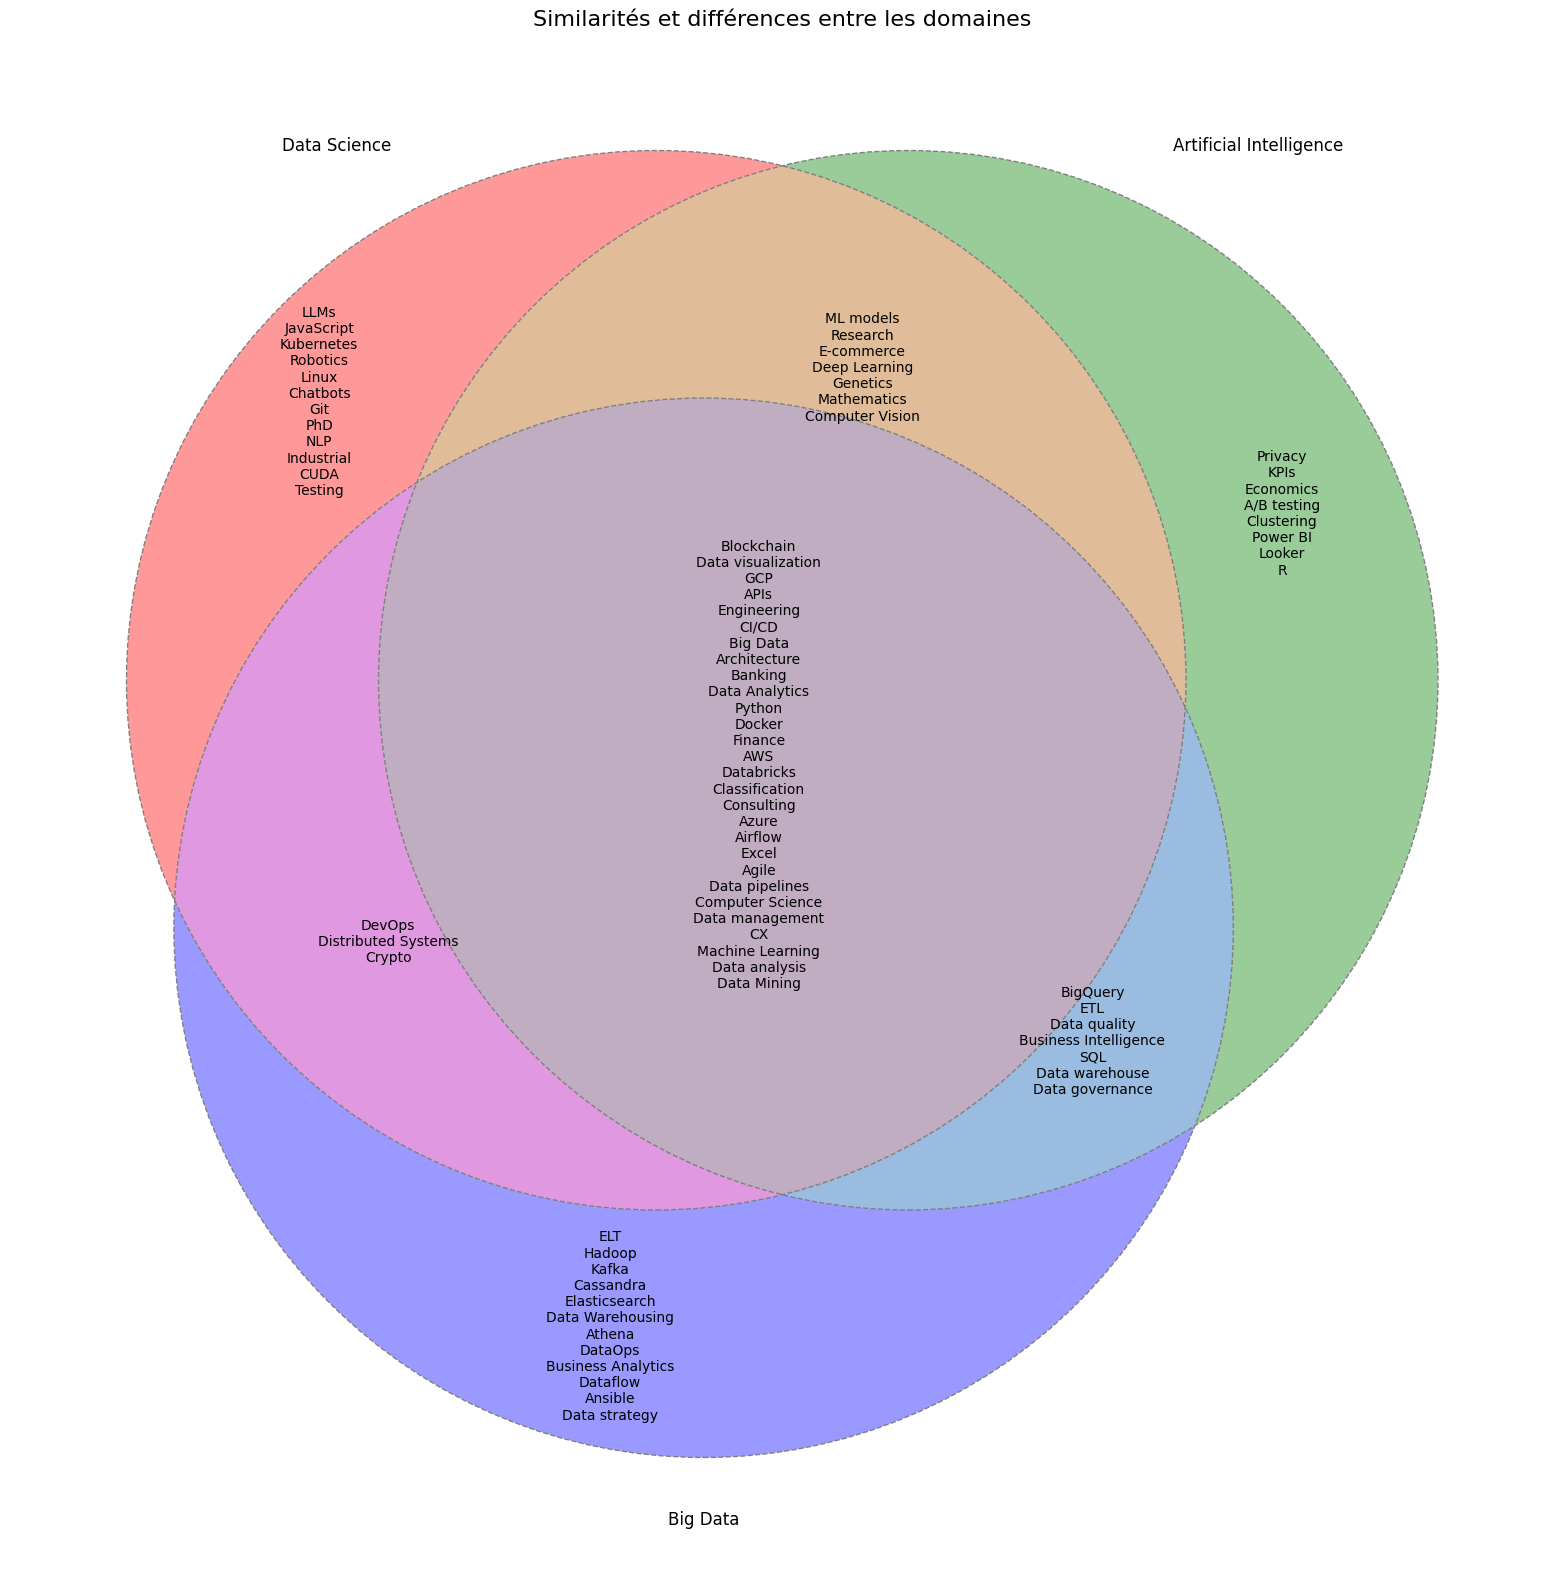

In [260]:
# Venn diagram to show differences and similarities between AI, DS and Big DATA
plt.figure(figsize=(20, 20))

# Number of rows
number_of_row = 50

data_science = set(data_science_skills['Skill'].head(number_of_row))
artificial_intelligence = set(ai_skills['Skill'].head(number_of_row))
big_data = set(big_data_skills['Skill'].head(number_of_row))

# Create the Venn diagram
venn = venn3([data_science, artificial_intelligence, big_data], set_labels=('Data Science', 'Artificial Intelligence', 'Big Data'))

# Add custom labels for each set
venn.get_label_by_id('100').set_text('\n'.join(artificial_intelligence - data_science - big_data))
venn.get_label_by_id('010').set_text('\n'.join(data_science - artificial_intelligence - big_data))
venn.get_label_by_id('001').set_text('\n'.join(big_data - artificial_intelligence - data_science))
venn.get_label_by_id('110').set_text('\n'.join(artificial_intelligence & data_science - big_data))
venn.get_label_by_id('101').set_text('\n'.join(artificial_intelligence & big_data - data_science))
venn.get_label_by_id('011').set_text('\n'.join(data_science & big_data - artificial_intelligence))
venn.get_label_by_id('111').set_text('\n'.join(artificial_intelligence & data_science & big_data))

# Customize the Venn diagram
venn_circles = venn3_circles([data_science, artificial_intelligence, big_data], linestyle='dashed', linewidth=1, color='grey')

plt.title('Similarités et différences entre les domaines', fontsize=16)
# Show the Venn diagram
plt.show()


### Les postes les plus courants

In [261]:
# Get most demanded jobs
result = session.query(Jobs.title, func.count(Jobs.title)).group_by(Jobs.title).order_by(desc(func.count(Jobs.title))).all()
most_job_title = {x[0]: x[1] for x in result}
most_job_title_df = pd.DataFrame(list(most_job_title.items()), columns=['Job Title', 'job_counts'])
most_job_title_df.head(10)

,Job Title,job_counts
0,data engineer,104
1,data scientist,78
2,data analyst,76
3,senior data engineer,63
4,machine learning engineer,47
5,senior data analyst,35
6,senior data scientist,32
7,senior machine learning engineer,21
8,analytics engineer,16
9,data architect,11


In [262]:
# Import wordcloud
from wordcloud import WordCloud

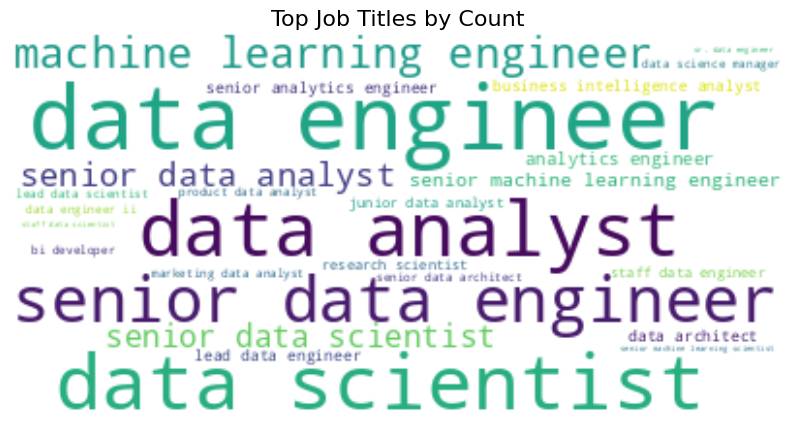

In [263]:
# Create a WordCloud object with custom settings
wordcloud = WordCloud(
    background_color='white',
    colormap='viridis',
    contour_color='steelblue',
    prefer_horizontal=1,  # Horizontal layout of words
    relative_scaling=0.5,  # Adjusts the font size based on counts
).generate_from_frequencies(most_job_title)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 6))  # Set the size of the figure (width, height)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Job Titles by Count', fontsize=16)

# Show the plot
plt.show()

### Les emplois les plus demandés et mieux payés pour chaque domaine

In [238]:
# Create function get job title by category
sql = text('''
    CREATE FUNCTION GetMostDemandedJobTitleByCategory(@categoryName VARCHAR(255))
    RETURNS TABLE
    AS
    RETURN 
    (
        SELECT j.title, COUNT(jc.job_id) AS job_count, AVG(j.salary) AS average_salary
        FROM jobs j
        JOIN job_categories jc ON j.id = jc.job_id
        JOIN categories c ON c.id = jc.category_id
        WHERE c.category = @categoryName
        GROUP BY j.title
    );
''')
             
with engine.connect() as conn:
    conn.execute(sql)
    conn.commit()

In [64]:
# Get most demand job title by category
def get_job_titles_count_by_category(category):
    # Query statement
    query = text('SELECT * FROM GetMostDemandedJobTitleByCategory(:categoryName) ORDER BY job_count DESC')
    result = session.execute(query, {'categoryName': category})

    # Execute statement
    most_demand_jobs = [[x[0], x[1], round(x[2], 2)] for x in result.all()]
    most_demand_jobs_df = pd.DataFrame(data=most_demand_jobs, columns=['job_title', 'job_count', 'average_salary'])
    
    return most_demand_jobs_df

In [62]:
# Get most payed demand job title by category
def get_job_titles_salary_by_category(category):
    # Query statement
    query = text('SELECT * FROM GetMostDemandedJobTitleByCategory(:categoryName) ORDER BY average_salary DESC')
    result = session.execute(query, {'categoryName': category})

    # Execute statement
    most_demand_jobs = [[x[0], x[1], round(x[2], 2)] for x in result.all()]
    most_demand_jobs_df = pd.DataFrame(data=most_demand_jobs, columns=['job_title', 'job_count', 'average_salary'])
    
    return most_demand_jobs_df

#### Data Science

In [264]:
# Get most demanded jobs in data science
data_science_jobs_count = get_job_titles_count_by_category('Data Science')
data_science_jobs_count.head()

,job_title,job_count,average_salary
0,data scientist,78,91384.62
1,data analyst,76,71973.68
2,machine learning engineer,47,98787.23
3,senior data analyst,35,95501.91
4,senior data scientist,32,124093.75


In [265]:
# Import math necessary packages
from math import pi

In [269]:
# Pie chart to show most demanded jobs in data science
head_number = 10
data_science_jobs_count = data_science_jobs_count.head(head_number)

data_science_jobs_count['angle'] = data_science_jobs_count['job_count']/data_science_jobs_count['job_count'].sum() * 2*pi
data_science_jobs_count['color'] = Category20c[len(data_science_jobs_count)]

p = figure(height=450, width=700, title="Emploi les plus demandés en Data Science", toolbar_location=None,
           tools="hover", tooltips="@job_title: @job_count", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='job_title', source=data_science_jobs_count.head(head_number))

p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

show(p)

In [270]:
# Get most payed job titles in data science
data_science_jobs_salary = get_job_titles_salary_by_category('Data Science')
data_science_jobs_salary.head()

,job_title,job_count,average_salary
0,"senior/principal ml engineer, content understa...",1,315000.0
1,senior data scientist - creator success,1,310000.0
2,senior data scientist - discovery experiences,1,295000.0
3,senior data scientist- creator content,1,295000.0
4,"principal software engineer, applied ml",1,283000.0


In [271]:
# Bar chart most payed jobs in data science
number_of_line = 10
job_titles = data_science_jobs_salary.head(number_of_line)['job_title']
average_salaries = data_science_jobs_salary.head(number_of_line)['average_salary']

# Create the bar chart
job_salaries_fig = px.bar(
    x=job_titles, 
    y=average_salaries, 
    labels={'x': 'Emplois', 'y': 'Salaires moyens'}, title='Les emplois les mieux payés en Data Science',
    color=average_salaries,
    color_continuous_scale='Greens'
)


# Customize the layout
job_salaries_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#538122',
    paper_bgcolor='#466624',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

# Show the plot in notebook
job_salaries_fig.show()

#### Big DATA

In [87]:
# Get most demanded jobs in big data
big_data_jobs_count = get_job_titles_count_by_category('Big Data')
big_data_jobs_count.head()

,job_title,job_count,average_salary
0,data engineer,104,95788.46
1,senior data engineer,63,111828.81
2,data architect,11,125909.09
3,lead data engineer,9,103000.00
4,staff data engineer,7,73142.86


In [272]:
# Pie chart to show most demanded jobs in big data
head_number = 10
big_data_jobs_count = big_data_jobs_count.head(head_number)

big_data_jobs_count['angle'] = big_data_jobs_count['job_count']/big_data_jobs_count['job_count'].sum() * 2*pi
big_data_jobs_count['color'] = Category20c[len(big_data_jobs_count)]

p = figure(height=450, width=750, title="Emploi les plus demandés en Big DATA", toolbar_location=None,
           tools="hover", tooltips="@job_title: @job_count", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='job_title', source=big_data_jobs_count.head(head_number))

p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

show(p)

In [91]:
# Get most payed job titles in big data
big_data_jobs_salary = get_job_titles_salary_by_category('Big DATA')
big_data_jobs_salary.head()

,job_title,job_count,average_salary
0,"principal software engineer, data engineering",1,283000.0
1,principal data engineer,1,225000.0
2,staff software engineer - streaming data pipel...,1,214000.0
3,presales data architect - streaming (remote us),1,204000.0
4,"sr. data integrations engineer, it enterprise ...",1,202000.0


In [274]:
# Bar chart most payed jobs in big data
number_of_line = 10
job_titles = big_data_jobs_salary.head(number_of_line)['job_title']
average_salaries = big_data_jobs_salary.head(number_of_line)['average_salary']

# Create the bar chart
job_salaries_fig = px.bar(
    x=job_titles, 
    y=average_salaries, 
    labels={'x': 'Emplois', 'y': 'Salaires moyens'}, title='Les emplois les mieux payés en Big DATA',
    color=average_salaries,
    color_continuous_scale='Reds'
)


# Customize the layout
job_salaries_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#538122',
    paper_bgcolor='#466624',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

# Show the plot in notebook
job_salaries_fig.show()

#### Artificial Intelligence

In [95]:
# Get most demanded jobs in AI
ai_jobs_count = get_job_titles_count_by_category('Artificial Intelligence')
ai_jobs_count.head()

,job_title,job_count,average_salary
0,machine learning engineer,47,98787.23
1,senior machine learning engineer,21,136761.90
2,senior machine learning scientist,5,129000.00
3,mlops engineer,4,59000.00
4,ml engineer,3,113000.00


In [273]:
# Pie chart to show most demanded jobs in AI
head_number = 10
ai_jobs_count = ai_jobs_count.head(head_number)

ai_jobs_count['angle'] = ai_jobs_count['job_count']/ai_jobs_count['job_count'].sum() * 2*pi
ai_jobs_count['color'] = Category20c[len(ai_jobs_count)]

p = figure(height=600, width=980, title="Emploi les plus demandés en Intelligence Artificielle", toolbar_location=None,
           tools="hover", tooltips="@job_title: @job_count", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='job_title', source=ai_jobs_count.head(head_number))

p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

show(p)

In [102]:
# Get most payed job titles in AI
ai_jobs_salary = get_job_titles_salary_by_category('Big DATA')
ai_jobs_salary.head()

,job_title,job_count,average_salary
0,"principal software engineer, data engineering",1,283000.0
1,principal data engineer,1,225000.0
2,staff software engineer - streaming data pipel...,1,214000.0
3,presales data architect - streaming (remote us),1,204000.0
4,"sr. data integrations engineer, it enterprise ...",1,202000.0


In [106]:
# Bar chart most payed jobs in AI
number_of_line = 10
job_titles = ai_jobs_salary.head(number_of_line)['job_title']
average_salaries = ai_jobs_salary.head(number_of_line)['average_salary']

# Create the bar chart
job_salaries_fig = px.bar(
    x=job_titles, 
    y=average_salaries, 
    labels={'x': 'Emplois', 'y': 'Salaires moyens'}, title='Les emplois les mieux payés en Intelligence Artificielle',
    color=average_salaries,
    color_continuous_scale='Blues'
)


# Customize the layout
job_salaries_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#101F6A',
    paper_bgcolor='#17266D',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

# Show the plot in notebook
job_salaries_fig.show()

### Niveau le plus demandé par domaine

In [237]:
# Create function get job levels by categories
sql = text('''
    CREATE FUNCTION GetLevelsByCategory(@categoryName VARCHAR(255))
    RETURNS TABLE
    AS
    RETURN 
    (
        SELECT el.level, jt.type, COUNT(jc.job_id) AS level_count
        FROM experience_levels el 
        JOIN jobs j ON el.id = j.experience_level_id
        LEFT JOIN job_types jt ON jt.id = j.job_type_id
        JOIN job_categories jc ON j.id = jc.job_id
        JOIN categories c ON c.id = jc.category_id
        WHERE c.category = @categoryName
        GROUP BY el.level, jt.type
    );
''')
             
with engine.connect() as conn:
    conn.execute(sql)
    conn.commit()

In [243]:
# Get most demand job title by category
def get_levels_by_category(category):
    # Query statement
    query = text('SELECT * FROM GetLevelsByCategory(:categoryName) ORDER BY level_count DESC')
    result = session.execute(query, {'categoryName': category})

    # Execute statement
    levels = [[x[0], x[1], x[2]] for x in result.all()]
    levels_df = pd.DataFrame(data=levels, columns=['levels', 'job_types', 'job_count'])
    
    return levels_df

In [335]:
# Grouped bar chart for most demanded levels and job types
def display_bar_level_type(level_type_df):
    # Pivot the data to get job counts for each combination of levels and job types
    pivot_df = level_type_df.pivot_table(index='levels', columns='job_types', values='job_count', fill_value=0)

    # Extract levels and job types from the pivot table
    levels = pivot_df.index.unique().tolist()
    job_types = pivot_df.columns.tolist()

    # Ensure that there are two colors in the palette to match the two unique job types
    palette = ["#101F6A", "#29E1E1"]

    # Create tuples for x-axis to form the combinations of levels and job types
    x = [(level, job_type) for level in levels for job_type in job_types]

    # Create a list of job counts corresponding to each x value
    counts = [pivot_df.loc[level, job_type] for level in levels for job_type in job_types]

    # Create the ColumnDataSource to organize the data for the plot
    source = ColumnDataSource(data=dict(x=x, counts=counts))

    # Create the figure
    p = figure(x_range=FactorRange(*x), height=350, title="Niveaux et types d'emploi les plus demandés en Data Science",
            toolbar_location=None, tools="")

    # Create the grouped bars using vbar
    p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white",
        fill_color=factor_cmap('x', palette=palette, factors=job_types, start=1, end=2))

    # Adjust the plot appearance
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    # Show the plot
    show(p)

#### Data Science

In [337]:
# Get levels in data science
data_science_levels_df = get_levels_by_category('data science')
data_science_levels_df

,levels,job_types,job_count
0,Senior-level,Full Time,1145
1,Mid-level,Full Time,290
2,Entry-level,Full Time,264
3,Not specified,Full Time,154
4,Executive-level,Full Time,88
5,Mid-level,Part Time,1


In [338]:
# Most demanded levels and job types in data science
display_bar_level_type(data_science_levels_df)

#### Big DATA

In [343]:
# Get levels in big data
big_data_levels_df = get_levels_by_category('big data')
big_data_levels_df

,levels,job_types,job_count
0,Senior-level,Full Time,456
1,Mid-level,Full Time,119
2,Entry-level,Full Time,59
3,Not specified,Full Time,47
4,Executive-level,Full Time,13
5,Mid-level,Part Time,1


In [344]:
# Most demanded levels and job types in bi data
display_bar_level_type(big_data_levels_df)

#### Artificial Intelligence

In [341]:
# Get levels in big data
ai_levels_df = get_levels_by_category('artificial intelligence')
ai_levels_df

,levels,job_types,job_count
0,Senior-level,Full Time,421
1,Mid-level,Full Time,85
2,Entry-level,Full Time,58
3,Not specified,Full Time,43
4,Executive-level,Full Time,24
5,Mid-level,Part Time,3


In [342]:
# Most demanded levels and job types in bi data
display_bar_level_type(ai_levels_df)

### Salaire minimum et maximum pour chaque domaine

In [403]:
# Get min and maximum salary for each category
sql = text('''
    SELECT c.category, MIN(j.salary) AS min_salary, MAX(j.salary) AS max_salary
    FROM jobs j
    JOIN job_categories jc ON j.id = jc.job_id
    JOIN categories c ON c.id = jc.category_id
    GROUP BY c.category
''')

result = session.execute(sql).fetchall()
min_max_salary_categories = [[x[0], x[1], x[2]] for x in result]
min_max_salary_categories_df = pd.DataFrame(min_max_salary_categories, columns=['categories', 'min_salaries', 'max_salaries'])
# min_max_salary_categories_df.drop(0, inplace=True)

In [404]:
min_max_salary_categories_df

,categories,min_salaries,max_salaries
0,Other,30000.0,283000.0
1,Artificial Intelligence,30000.0,315000.0
2,Data Science,30000.0,315000.0
3,Big Data,30000.0,283000.0


In [396]:

# Multi bar for max and min salary per category
categories = min_max_salary_categories_df['categories']
years = ["min_salaries", "max_salaries"]

# Create the dictionary to pass to ColumnDataSource
data = {
    'categories': categories,
    'min_salaries': min_max_salary_categories_df['min_salaries'],
    'max_salaries': min_max_salary_categories_df['max_salaries']
}

palette = ["#101F6A", "#29E1E1"]
source = ColumnDataSource(data=data)

# Create the figure
p = figure(x_range=categories, height=450, title="Minimum and Maximum Salaries by Category",
           toolbar_location=None, tools="hover", tooltips=[("Category", "@categories"), ("Min Salary", "@min_salaries"), ("Max Salary", "@max_salaries")])

# Create the bars for minimum salaries
p.vbar(x=dodge('categories', -0.15, range=p.x_range), top='min_salaries', source=source,
       width=0.3, color=palette[0], legend_label="Min Salary")

# Create the bars for maximum salaries with an offset
p.vbar(x=dodge('categories', 0.15, range=p.x_range), top='max_salaries', source=source,
       width=0.3, color=palette[1], legend_label="Max Salary")

# Adjust the plot appearance
p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

# Show the plot
show(p)
